In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/501_NOX.csv')
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"], format='mixed')
df = df.set_index('DATE_TIME')

df.head()

,NOX
DATE_TIME,
2021-11-28,55.002945
2021-11-29,158.527592
2021-11-30,29.384567
2021-12-01,88.812013
2021-12-02,72.022601


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 731 entries, 2021-11-28 to 2023-11-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NOX     731 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB



--- Interrupted Time Series Analysis Summary ---
                            OLS Regression Results                            
Dep. Variable:                    NOX   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     14.11
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           6.02e-09
Time:                        10:43:24   Log-Likelihood:                -3784.5
No. Observations:                 731   AIC:                             7577.
Df Residuals:                     727   BIC:                             7595.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

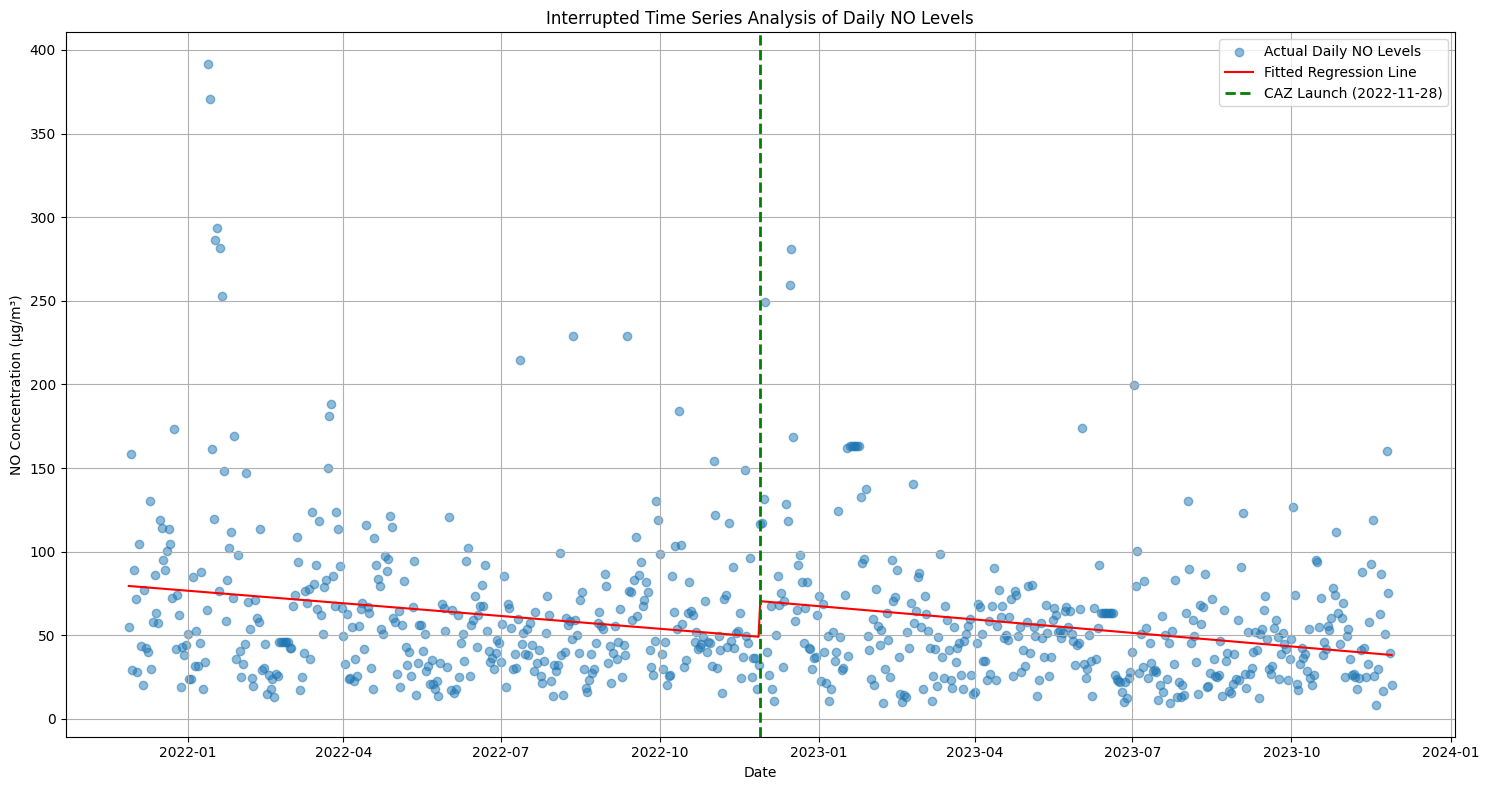

In [4]:
pollution_col = 'NOX'
df[pollution_col] = pd.to_numeric(df[pollution_col], errors='coerce')

daily_df = df[[pollution_col]].resample('D').mean()
daily_df = daily_df.interpolate(method='linear')

caz_launch_date = pd.to_datetime('2022-11-28')

daily_df['time'] = (daily_df.index - daily_df.index.min()).days

daily_df['intervention'] = (daily_df.index >= caz_launch_date).astype(int)

daily_df['post_time'] = daily_df['time'] * daily_df['intervention']

X = daily_df[['time', 'intervention', 'post_time']]
y = daily_df[pollution_col]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print("\n--- Interrupted Time Series Analysis Summary ---")
print(model.summary())

daily_df['predicted'] = model.predict(X)

plt.figure(figsize=(15, 8))
plt.scatter(daily_df.index, daily_df[pollution_col], alpha=0.5, label='Actual Daily NO Levels')
plt.plot(daily_df.index, daily_df['predicted'], color='red', label='Fitted Regression Line')

plt.axvline(caz_launch_date, color='green', linestyle='--', linewidth=2, label='CAZ Launch (2022-11-28)')

plt.title('Interrupted Time Series Analysis of Daily NO Levels')
plt.xlabel('Date')
plt.ylabel('NO Concentration (µg/m³)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()